In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from skimage.transform import resize
from skimage.io import imread, imshow
from tensorflow import keras
data_path = '../input/data12'

# x_train (pure images from dataset)

In [2]:
# images = os.listdir(image_data_path)
# images.sort()
# print('Total images : ', len(images))

# masks = os.listdir(mask_data_path)
# masks.sort()
# print('Total masks: ', len(masks))

# n = 53 # 20% of total

# test_images  = images[:n]
# test_masks  = masks[:n]

# train_images = images[n:]
# train_masks = images[n:]

# print('train_images len: ', len(train_images))
# print('train_masks len: ', len(train_masks))

# print('test_images len: ', len(test_images))
# print('test_masks len: ', len(test_masks))

(265, 512, 512, 3)
uint8


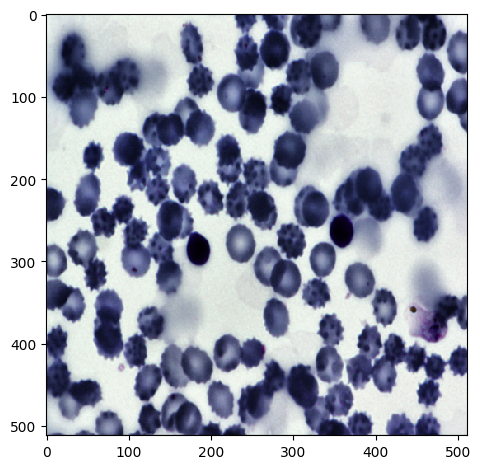

In [ ]:
image_data_path ='/kaggle/input/testdata12/test/Original'
mask_data_path ='/kaggle/input/testdata12/test/Mask'

row = 512
columns = 512

# train_data_path = os.path.join(data_path, 'train')
train_data_path ='/kaggle/input/testdata12/test/Original'
training_images = os.listdir(train_data_path)
training_images.sort()

# training_images = images[1::2]
# training_masks = images[::2]
# print(len(training_images)) #20
# print(len(training_masks))

X = np.zeros((len(training_images), row, columns, 3), dtype=np.uint8)

index = 0
for x in training_images:
    path = os.path.join(image_data_path, x)
    image = imread(path)
    image = resize(image, (row, columns), mode='constant', preserve_range=True)
    # image.resize((128,128,1))
    X[index] = image
    index += 1

print(X.shape)
#x_train = x_train / 255
#x_train = x_train.astype('float32')
# X = X.astype('float32')
print(X.dtype)
imshow(X[0])

# y_train (pure masks from dataset)

(265, 512, 512, 3)
uint8


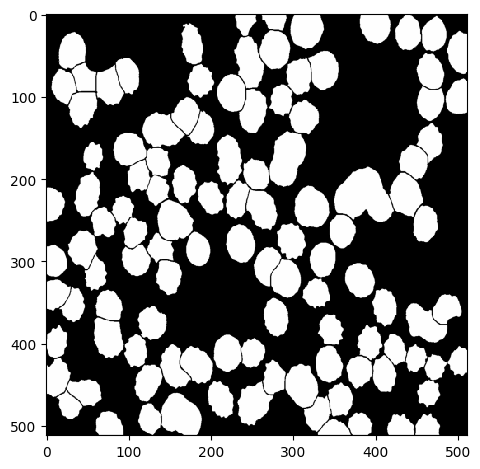

In [ ]:
train_data_path ='/kaggle/input/testdata12/test/Mask'
training_masks = os.listdir(train_data_path)
training_masks.sort()

y = np.zeros((len(training_masks), row, columns, 3), dtype=np.uint8)
#p = os.path.join(train_data_path, training_masks[0])
#i = imread(p)
#k = resize(i, (128, 128))
#imshow(k)

index = 0
for x in training_masks:
    path = os.path.join(mask_data_path, x)
#     print(path)
    image = imread(path)
    image = resize(image, (row, columns), mode='constant', preserve_range=True)
    #image.resize((128,128,1))
    y[index] = image
    index += 1

print(y.shape)
type(y)
#y_train = y_train / 255
#y_train = y_train.astype('float32')
print(y.dtype)
imshow(y[0])

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)

# X_train = X_train.astype('float32')
# y_train = y_train.astype('float32')

# X_test = X_test.astype('float32')
# y_test = y_test.astype('float32')

# print(X_train.dtype)
# print(y_train.dtype)
# print()
# print(X_test.dtype)
# print(y_test.dtype)

(212, 512, 512, 3)
(212, 512, 512, 3)

(53, 512, 512, 3)
(53, 512, 512, 3)


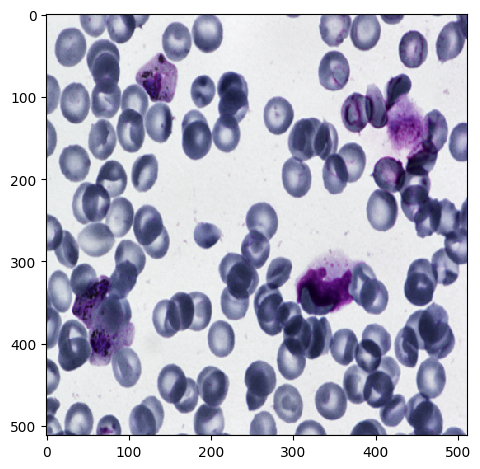

In [ ]:
imshow(X_train[0])

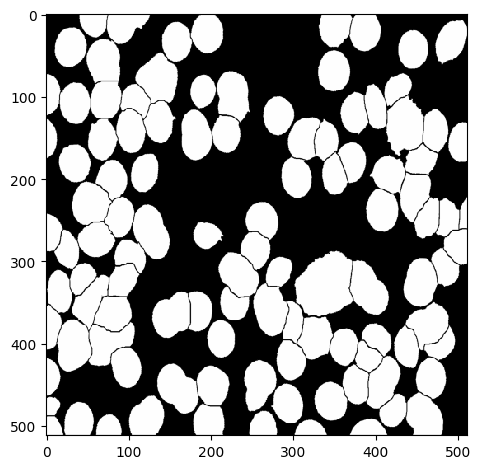

In [ ]:
imshow(y_train[0])

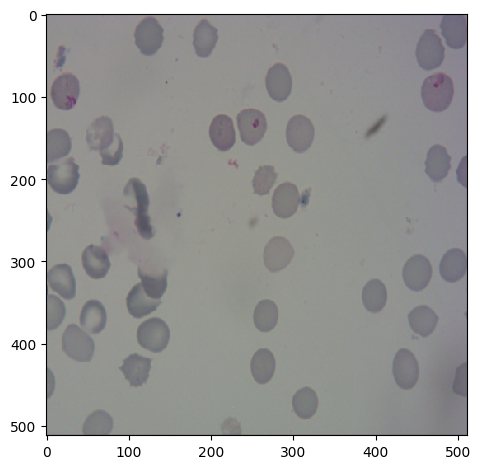

In [ ]:
imshow(X_test[0])

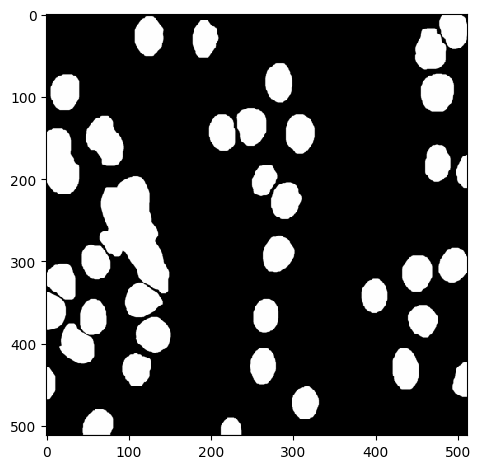

In [ ]:
imshow(y_test[0])

In [ ]:
y_train = y_train.astype('bool')
print(y_train.dtype)

bool


# Libraries

In [ ]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.backend as K
import tensorflow.keras.backend as K
import tensorflow as tf

# Metrics

In [ ]:
def dice_coef(a, b):
    hi = a
#     hi = tf.dtypes.cast(hi, tf.float32)
    pred = b
    hi = keras.layers.Flatten()(hi)   #K.flatten(hi)
    pred = keras.layers.Flatten()(pred) #K.flatten(pred)
    upper_part = 2 * tf.keras.backend.sum((hi * pred))
    lower_part = tf.keras.backend.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def jaccard_index(a, b):
    hi = a
#     hi = tf.dtypes.cast(hi, tf.float32)
    pred = b
    hi = keras.layers.Flatten()(hi)     #K.flatten(hi)
    pred = keras.layers.Flatten()(pred) #K.flatten(pred)
    numerator = tf.keras.backend.sum(hi * pred)
    denominator = tf.keras.backend.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

# U-Net

In [ ]:
inputs = Input((row, columns, 3))

s = Lambda(lambda x: x/255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(3, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.5,
    staircase=True)

opt = keras.optimizers.Adam(learning_rate=0.001)

#model.compile(optimizer='adam', loss='binary_crossentropy')
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[dice_coef, jaccard_index]) #[dice_coef, jaccard_index]

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 512,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,941,139 (7.40 MB)

 Trainable params: 1,941,139 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(X_train.dtype)
print(y_train.dtype)

print(type(X_train))
print(type(y_train))

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

print(X_train.dtype)
print(y_train.dtype)

uint8
bool
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
float32
float32


In [ ]:
print(X_train.shape)
print(y_train.shape)
filepath = "/kaggle/working/model.keras"
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#mode='min'
callbacks_list = [earlystopper, checkpoint]
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=1, epochs=5, callbacks=callbacks_list)

(212, 512, 512, 3)
(212, 512, 512, 3)
Epoch 1/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.4729 - jaccard_index: 0.3346 - loss: 0.4804
Epoch 1: val_loss improved from inf to 0.14943, saving model to /kaggle/working/model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - dice_coef: 0.4737 - jaccard_index: 0.3354 - loss: 0.4797 - val_dice_coef: 0.8192 - val_jaccard_index: 0.7288 - val_loss: 0.1494
Epoch 2/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.8071 - jaccard_index: 0.6993 - loss: 0.2055
Epoch 2: val_loss improved from 0.14943 to 0.10549, saving model to /kaggle/working/model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - dice_coef: 0.8073 - jaccard_index: 0.6996 - loss: 0.2053 - val_dice_coef: 0.8610 - val_jaccard_index: 0.7800 - val_loss: 0.1055
Epoch 3/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.8838 - jaccard_index: 0.8032 - loss: 0.1253
Epoch 3: val_loss improved from 0.10549 to 0.10199, saving model to /kaggle/working/model.keras
190/190

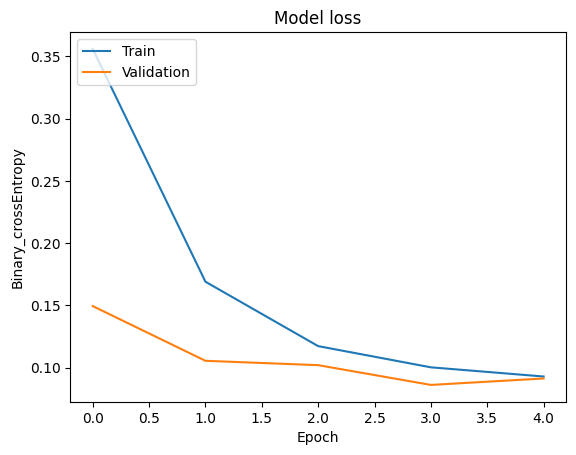

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

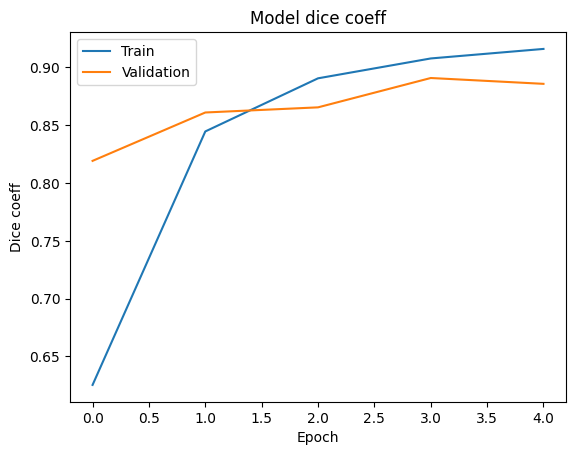

In [ ]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

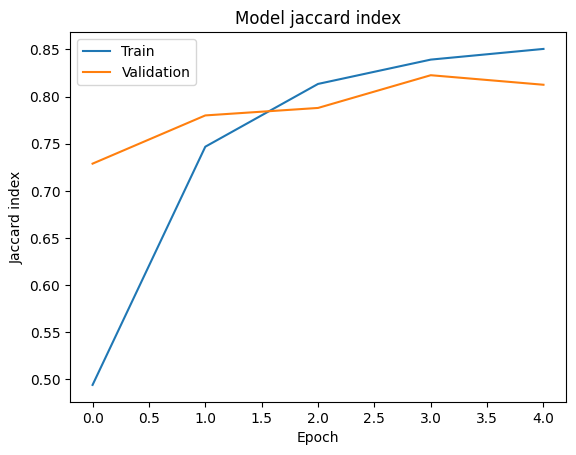

In [ ]:
plt.plot(history.history['jaccard_index'])
plt.plot(history.history['val_jaccard_index'])
plt.title('Model jaccard index')
plt.ylabel('Jaccard index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Testing

In [ ]:
X_test = X_test.astype('float32')
y_test = y_test.astype('float64')

In [ ]:
model.load_weights('/kaggle/working/model.keras')

test_preds = model.predict(X_test)
print(test_preds.shape)
print(type(test_preds))

2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 8s/step
(53, 512, 512, 3)
<class 'numpy.ndarray'>


# Evaluating Individual Dice-Co efficient
# Metrics for individual evaluation

In [ ]:
def dice_coef2(a, b):
          #  hi = K.hi
          #  hi = hi / 255

          #    hi = tf.convert_to_tensor(hi, dtype=None)
          #    pred = tf.convert_to_tensor(test_preds, dtype=None)
    hi = a/255
    pred = b
    hi = keras.layers.Flatten()(hi) # K.flatten(hi)
    pred = keras.layers.Flatten()(pred) #K.flatten(pred)
    upper_part = 2 * tf.keras.backend.sum((hi * pred))
    lower_part = tf.keras.backend.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def jaccard_index2(a, b):
    hi = a/255
    pred = b
    hi = keras.layers.Flatten()(hi)     #K.flatten(hi)
    pred = keras.layers.Flatten()(pred) #K.flatten(pred)
    numerator = tf.keras.backend.sum(hi * pred)
    denominator = tf.keras.backend.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

float64
float32
Dice Co-efficient:  tf.Tensor(0.66318196, shape=(), dtype=float32)
Jaccard-index:  tf.Tensor(0.49608994, shape=(), dtype=float32)


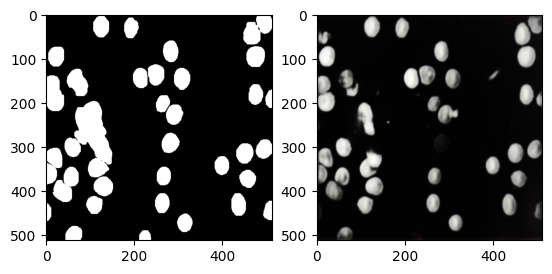

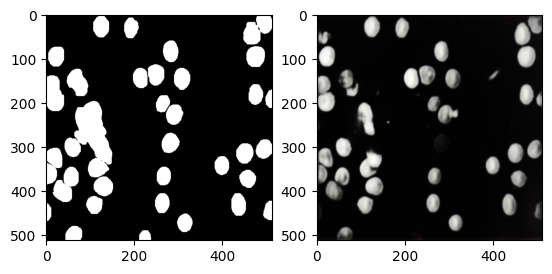

In [ ]:
from skimage.io import imshow_collection
print(y_test[0].dtype)
print(test_preds[0].dtype)
i = y_test[0]
j = test_preds[0]
#i = np.asarray(i).astype(dtype=np.float32)
result = dice_coef2(i,j)
#print(tf.get_static_value(result))
print('Dice Co-efficient: ', result)
result2 = jaccard_index2(i,j)
print('Jaccard-index: ', result2)
x = np.zeros((2, row, columns, 3))
x[0] = i
x[1] = j
imshow_collection(x)

# Average Test Dice Co-efficient, Jaccard index

In [ ]:
#dice_list = np.array(len(test_preds))
#jaccard_list = np.array(len(test_preds))
avg_dice = 0
avg_jaccard = 0
for x in range(len(test_preds)):
    i = y_test[x]
    j = test_preds[x]
    avg_dice = avg_dice + tf.get_static_value(dice_coef2(i,j))
    avg_jaccard = avg_jaccard + tf.get_static_value(jaccard_index2(i,j))

#print(dice_list.dtype)
#print(type(dice_list))
#print(dice_list)
#print(jaccard_list)
#avg_dice = tf.get_static_value(K.sum(dice_list)) / tf.get_static_value(tf.size(dice_list))
#avg_jaccard = tf.get_static_value(K.sum(jaccard_list)) / tf.get_static_value(tf.size(jaccard_list))
print('Average Test Dice co-efficent: ', avg_dice/len(test_preds))
print('Average Test Jaccrad Index: ', avg_jaccard/len(test_preds))

Average Test Dice co-efficent:  0.8891363987382853
Average Test Jaccrad Index:  0.8091817897445751


# Highest & Lowest

In [ ]:
print('Lowest training loss: ', min(history.history['loss']))
print('Lowest validation loss: ', min(history.history['val_loss']))
print('Highest training dice coefficient: ', max(history.history['dice_coef']))
print('Highest validation dice coefficient: ', max(history.history['val_dice_coef']))
print('Highest training jaccrad index: ', max(history.history['jaccard_index']))
print('Highest validation jaccard index: ', max(history.history['val_jaccard_index']))

Lowest training loss:  0.09287779778242111
Lowest validation loss:  0.08612184226512909
Highest training dice coefficient:  0.9160227179527283
Highest validation dice coefficient:  0.8908593654632568
Highest training jaccrad index:  0.850497841835022
Highest validation jaccard index:  0.8226061463356018
